# Mistral Classifier Factory: Entity Taxonomy Classification

This notebook demonstrates how to use Mistral's Classifier Factory to replace SetFit in your entity resolution pipeline. We'll train a multi-label classifier to categorize entities based on your parallel classifications.

## Features
- Multi-label classification (handling 190 entities with 2+ domains, 9 with 3 domains)
- Data preparation from your `parallel_classifications.json`
- Complete training workflow with monitoring
- Inference and evaluation
- Integration with entity resolution pipeline

## Prerequisites
- Mistral API key (set `MISTRAL_API_KEY` environment variable)
- Required packages: `mistralai`, `pandas`, `matplotlib`, `seaborn`

In [1]:
# Install required packages if needed
!pip install mistralai pandas matplotlib seaborn wandb weave

  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 12.0 MB/s eta 0:00:000:00:010:00:014
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.2/542.2 kB 20.4 MB/s eta 0:00:00
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.9 MB/s eta 0:00:00
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import wandb
import weave
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Optional
from mistralai import Mistral

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configuration
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("../data/output")
RANDOM_SEED = 42

# Set random seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("🚀 Environment setup complete!")
print("📊 Weights & Biases support enabled")

🚀 Environment setup complete!
📊 Weights & Biases support enabled


## 1. Data Loading and Exploration

Let's start by loading and exploring your entity data and parallel classifications.

In [5]:
def load_entity_data(csv_path: str) -> pd.DataFrame:
    """Load entity data with composite text."""
    print(f"Loading entity data from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} entities")
    print(f"Unique personIds: {df['personId'].nunique()}")
    return df

def load_parallel_classifications(json_path: str) -> Dict:
    """Load parallel classifications."""
    print(f"Loading parallel classifications from {json_path}...")
    with open(json_path, 'r', encoding='utf-8') as f:
        classifications = json.load(f)
    print(f"Loaded classifications for {len(classifications)} entities")
    return classifications

# Load data
entity_df = load_entity_data(DATA_DIR / "input" / "training_dataset.csv")
classifications = load_parallel_classifications(DATA_DIR / "input" / "parallel_classifications.json")

# Display sample entity data
print("\n📊 Sample entity data:")
print(entity_df[['personId', 'person', 'composite']].head(3))

Loading entity data from ../data/input/training_dataset.csv...
Loaded 2539 entities
Unique personIds: 2539
Loading parallel classifications from ../data/input/parallel_classifications.json...
Loaded classifications for 2539 entities

📊 Sample entity data:
                 personId                      person  \
0       53144#Agent700-22             Schubert, Franz   
1      772230#Agent100-15  Schubert, Franz, 1797-1828   
2  772230#Hub240-16-Agent  Schubert, Franz, 1797-1828   

                                           composite  
0  Roles: Contributor\nTitle: Archäologie und Ph...  
1  Roles: Contributor\nTitle: Quartette für zwei...  
2  Roles: Contributor\nTitle: Quartette für zwei...  


In [6]:
# Explore classification structure
print("🔍 Sample classification structure:")
sample_key = list(classifications.keys())[0]
sample_classification = classifications[sample_key]
print(f"PersonID: {sample_key}")
print(f"Labels: {sample_classification['label']}")
print(f"Paths: {sample_classification['path']}")
print(f"Rationale: {sample_classification['rationale'][:200]}...")

🔍 Sample classification structure:
PersonID: 53144#Agent700-22
Labels: ['Documentary and Technical Arts', 'History, Heritage, and Memory']
Paths: ['Arts, Culture, and Creative Expression > Documentary and Technical Arts', 'Humanities, Thought, and Interpretation > History, Heritage, and Memory']
Rationale: This catalog entry describes Franz Schubert as a contributor to 'Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode' (Archaeology and Photography: fifty examples of history and...


## 2. Multi-Label Analysis

Let's analyze the multi-label structure of your data to understand the complexity we're dealing with.

In [7]:
def analyze_label_distribution(classifications: Dict) -> Dict:
    """Comprehensive analysis of label distribution."""
    
    # Count labels per entity
    label_counts = []
    domain_frequency = defaultdict(int)
    parent_frequency = defaultdict(int)
    domain_combinations = defaultdict(int)
    parent_spans = 0
    
    for person_id, data in classifications.items():
        labels = data.get('label', [])
        paths = data.get('path', [])
        
        label_counts.append(len(labels))
        
        # Count individual domains
        for label in labels:
            domain_frequency[label] += 1
        
        # Extract and count parent categories
        parents = []
        for path in paths:
            if " > " in path:
                parent = path.split(" > ")[0]
                parents.append(parent)
                parent_frequency[parent] += 1
        
        # Count entities spanning multiple parent categories
        if len(set(parents)) > 1:
            parent_spans += 1
        
        # Track domain combinations for multi-label entities
        if len(labels) > 1:
            combo = tuple(sorted(labels))
            domain_combinations[combo] += 1
    
    return {
        'label_counts': label_counts,
        'domain_frequency': dict(domain_frequency),
        'parent_frequency': dict(parent_frequency),
        'domain_combinations': dict(domain_combinations),
        'parent_spans': parent_spans
    }

# Analyze the data
analysis = analyze_label_distribution(classifications)

# Display key statistics
label_counts = analysis['label_counts']
print("📈 Multi-Label Statistics:")
print(f"  Total entities: {len(label_counts)}")
print(f"  Single domain: {label_counts.count(1)} ({label_counts.count(1)/len(label_counts)*100:.1f}%)")
print(f"  Dual domain: {label_counts.count(2)} ({label_counts.count(2)/len(label_counts)*100:.1f}%)")
print(f"  Triple domain: {label_counts.count(3)} ({label_counts.count(3)/len(label_counts)*100:.1f}%)")
print(f"  Multi-parent spans: {analysis['parent_spans']} ({analysis['parent_spans']/len(label_counts)*100:.1f}%)")

📈 Multi-Label Statistics:
  Total entities: 2539
  Single domain: 2349 (92.5%)
  Dual domain: 181 (7.1%)
  Triple domain: 9 (0.4%)
  Multi-parent spans: 93 (3.7%)


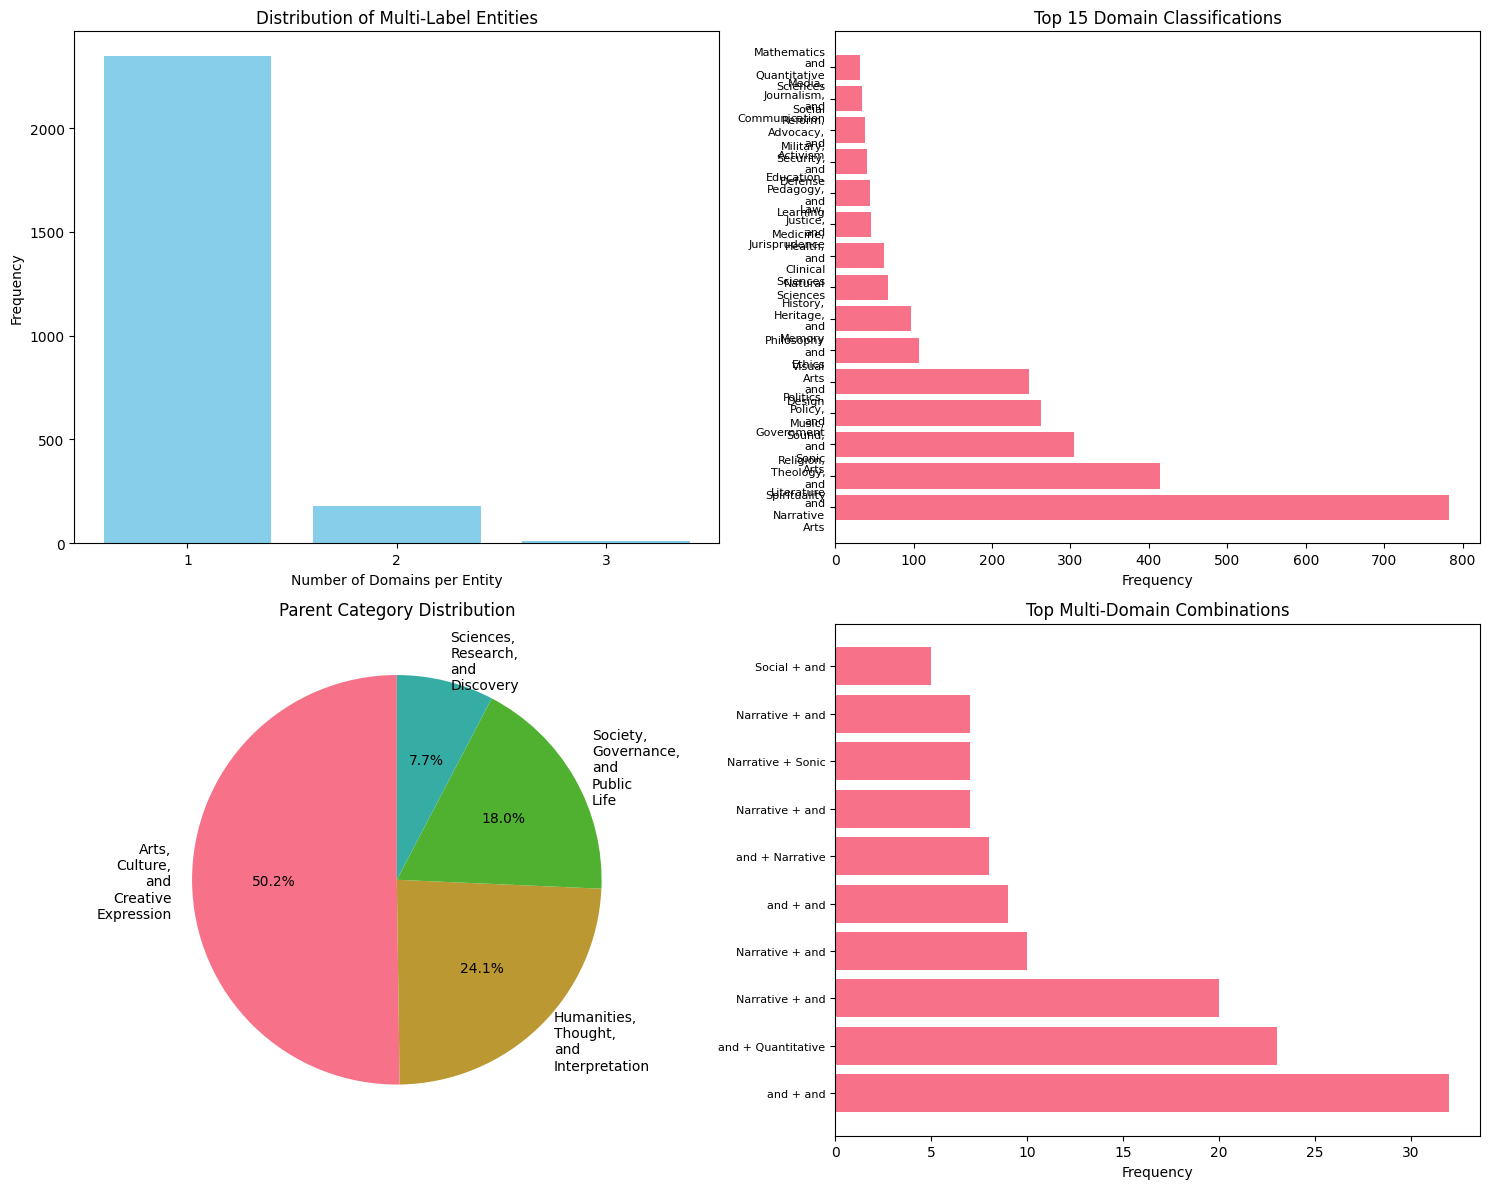


🎯 Key Insights:
  Most common domain: Literature and Narrative Arts
  Most common combination: ('Military, Security, and Defense', 'Politics, Policy, and Government')
  Cross-parent entities: 93 entities span multiple top-level categories


In [5]:
# Visualize label distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Label count distribution
label_count_freq = Counter(analysis['label_counts'])
ax1.bar(label_count_freq.keys(), label_count_freq.values(), color='skyblue')
ax1.set_xlabel('Number of Domains per Entity')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Multi-Label Entities')
ax1.set_xticks(list(label_count_freq.keys()))

# 2. Top 15 domains
top_domains = dict(sorted(analysis['domain_frequency'].items(), key=lambda x: x[1], reverse=True)[:15])
ax2.barh(range(len(top_domains)), list(top_domains.values()))
ax2.set_yticks(range(len(top_domains)))
ax2.set_yticklabels([label.replace(' ', '\n') for label in top_domains.keys()], fontsize=8)
ax2.set_xlabel('Frequency')
ax2.set_title('Top 15 Domain Classifications')

# 3. Parent categories
parents = analysis['parent_frequency']
ax3.pie(parents.values(), labels=[p.replace(' ', '\n') for p in parents.keys()], 
        autopct='%1.1f%%', startangle=90)
ax3.set_title('Parent Category Distribution')

# 4. Top multi-domain combinations
top_combos = dict(sorted(analysis['domain_combinations'].items(), key=lambda x: x[1], reverse=True)[:10])
combo_labels = [' + '.join([d.split()[-2:][0] if len(d.split()) > 2 else d.split()[0] for d in combo]) 
                for combo in top_combos.keys()]
ax4.barh(range(len(top_combos)), list(top_combos.values()))
ax4.set_yticks(range(len(top_combos)))
ax4.set_yticklabels(combo_labels, fontsize=8)
ax4.set_xlabel('Frequency')
ax4.set_title('Top Multi-Domain Combinations')

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print(f"  Most common domain: {max(analysis['domain_frequency'], key=analysis['domain_frequency'].get)}")
print(f"  Most common combination: {max(analysis['domain_combinations'], key=analysis['domain_combinations'].get) if analysis['domain_combinations'] else 'None'}")
print(f"  Cross-parent entities: {analysis['parent_spans']} entities span multiple top-level categories")

## 3. Data Preparation for Mistral

Now let's prepare the data in Mistral's expected format. Based on the official cookbook, we'll use proper multi-label structure.

In [6]:
def prepare_mistral_dataset(entity_df: pd.DataFrame, classifications: Dict) -> List[Dict]:
    """Prepare dataset in Mistral Classifier Factory format."""
    
    # Create lookup for composite text
    composite_lookup = {}
    for _, row in entity_df.iterrows():
        person_id = str(row['personId'])
        composite_lookup[person_id] = row['composite']
    
    training_examples = []
    skipped_no_composite = 0
    skipped_no_labels = 0
    
    for person_id, classification_data in classifications.items():
        # Get composite text
        composite_text = composite_lookup.get(person_id)
        if not composite_text:
            skipped_no_composite += 1
            continue
        
        # Extract labels and paths
        labels_list = classification_data.get('label', [])
        paths_list = classification_data.get('path', [])
        
        if not labels_list:
            skipped_no_labels += 1
            continue
        
        # Extract parent categories from paths
        parent_categories = []
        for path in paths_list:
            if " > " in path:
                parent_categories.append(path.split(" > ")[0])
        
        # Create Mistral labels using native multi-label format
        # Following the cookbook pattern but adapted for our taxonomy
        mistral_labels = {
            "domain": labels_list,  # Native multi-label: list of domains
            "parent_category": parent_categories  # List of parent categories
        }
        
        training_examples.append({
            "text": composite_text,
            "labels": mistral_labels
        })
    
    print(f"📝 Dataset preparation complete:")
    print(f"  Created: {len(training_examples)} training examples")
    print(f"  Skipped (no composite): {skipped_no_composite}")
    print(f"  Skipped (no labels): {skipped_no_labels}")
    
    return training_examples

# Prepare the dataset
training_examples = prepare_mistral_dataset(entity_df, classifications)

# Show sample examples
print("\n🔍 Sample training examples:")
for i, example in enumerate(training_examples[:3]):
    print(f"\nExample {i+1}:")
    print(f"  Text: {example['text'][:100]}...")
    print(f"  Domains: {example['labels']['domain']}")
    print(f"  Parents: {example['labels']['parent_category']}")

📝 Dataset preparation complete:
  Created: 2539 training examples
  Skipped (no composite): 0
  Skipped (no labels): 0

🔍 Sample training examples:

Example 1:
  Text: Roles: Contributor
Title: Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Metho...
  Domains: ['Documentary and Technical Arts', 'History, Heritage, and Memory']
  Parents: ['Arts, Culture, and Creative Expression', 'Humanities, Thought, and Interpretation']

Example 2:
  Text: Roles: Contributor
Title: Quartette für zwei Violinen, Viola, Violoncell
Attribution: von Franz Sch...
  Domains: ['Music, Sound, and Sonic Arts']
  Parents: ['Arts, Culture, and Creative Expression']

Example 3:
  Text: Roles: Contributor
Title: Quartette für zwei Violinen, Viola, Violoncell
Version of: Quartets, viol...
  Domains: ['Music, Sound, and Sonic Arts']
  Parents: ['Arts, Culture, and Creative Expression']


In [7]:
def split_dataset(examples: List[Dict], val_ratio: float = 0.2, test_ratio: float = 0.1) -> Tuple[List[Dict], List[Dict], List[Dict]]:
    """Split dataset into train/validation/test sets with stratification by number of labels."""
    
    # Group by number of domains for stratified split
    single_domain = [ex for ex in examples if len(ex['labels']['domain']) == 1]
    multi_domain = [ex for ex in examples if len(ex['labels']['domain']) > 1]
    
    def split_group(group_examples: List[Dict]) -> Tuple[List[Dict], List[Dict], List[Dict]]:
        random.shuffle(group_examples)
        n = len(group_examples)
        test_size = int(n * test_ratio)
        val_size = int(n * val_ratio)
        
        test_set = group_examples[:test_size]
        val_set = group_examples[test_size:test_size + val_size]
        train_set = group_examples[test_size + val_size:]
        
        return train_set, val_set, test_set
    
    # Split each group
    single_train, single_val, single_test = split_group(single_domain)
    multi_train, multi_val, multi_test = split_group(multi_domain)
    
    # Combine
    train_set = single_train + multi_train
    val_set = single_val + multi_val
    test_set = single_test + multi_test
    
    # Final shuffle
    random.shuffle(train_set)
    random.shuffle(val_set)
    random.shuffle(test_set)
    
    print(f"📊 Dataset split:")
    print(f"  Training: {len(train_set)} examples")
    print(f"  Validation: {len(val_set)} examples")
    print(f"  Test: {len(test_set)} examples")
    
    return train_set, val_set, test_set

# Split the dataset
train_examples, val_examples, test_examples = split_dataset(training_examples)

# Analyze split quality
def analyze_split_quality(train: List[Dict], val: List[Dict], test: List[Dict]):
    """Analyze the quality of the train/val/test split."""
    
    def get_label_stats(examples: List[Dict]) -> Dict:
        domain_counts = defaultdict(int)
        parent_counts = defaultdict(int)
        multi_label_count = 0
        
        for ex in examples:
            domains = ex['labels']['domain']
            parents = ex['labels']['parent_category']
            
            if len(domains) > 1:
                multi_label_count += 1
            
            for domain in domains:
                domain_counts[domain] += 1
            
            for parent in set(parents):
                parent_counts[parent] += 1
        
        return {
            'total': len(examples),
            'multi_label': multi_label_count,
            'multi_label_pct': multi_label_count / len(examples) * 100,
            'unique_domains': len(domain_counts),
            'unique_parents': len(parent_counts)
        }
    
    train_stats = get_label_stats(train)
    val_stats = get_label_stats(val)
    test_stats = get_label_stats(test)
    
    print("\n🎯 Split Quality Analysis:")
    print(f"                Train    Val      Test")
    print(f"Total:          {train_stats['total']:5d}    {val_stats['total']:5d}    {test_stats['total']:5d}")
    print(f"Multi-label:    {train_stats['multi_label']:5d}    {val_stats['multi_label']:5d}    {test_stats['multi_label']:5d}")
    print(f"Multi-label %:  {train_stats['multi_label_pct']:5.1f}    {val_stats['multi_label_pct']:5.1f}    {test_stats['multi_label_pct']:5.1f}")
    print(f"Unique domains: {train_stats['unique_domains']:5d}    {val_stats['unique_domains']:5d}    {test_stats['unique_domains']:5d}")
    print(f"Unique parents: {train_stats['unique_parents']:5d}    {val_stats['unique_parents']:5d}    {test_stats['unique_parents']:5d}")

analyze_split_quality(train_examples, val_examples, test_examples)

📊 Dataset split:
  Training: 1779 examples
  Validation: 507 examples
  Test: 253 examples

🎯 Split Quality Analysis:
                Train    Val      Test
Total:           1779      507      253
Multi-label:      133       38       19
Multi-label %:    7.5      7.5      7.5
Unique domains:    24       22       22
Unique parents:     4        4        4


In [8]:
def save_jsonl(examples: List[Dict], filepath: str):
    """Save examples in JSONL format."""
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    with open(filepath, 'w', encoding='utf-8') as f:
        for example in examples:
            f.write(json.dumps(example, ensure_ascii=False) + '\n')
    
    print(f"💾 Saved {len(examples)} examples to {filepath}")

# Save the datasets
save_jsonl(train_examples, OUTPUT_DIR / "mistral_train.jsonl")
save_jsonl(val_examples, OUTPUT_DIR / "mistral_val.jsonl")
save_jsonl(test_examples, OUTPUT_DIR / "mistral_test.jsonl")

print("\n✅ Data preparation complete! Ready for Mistral training.")

💾 Saved 1779 examples to ../data/output/mistral_train.jsonl
💾 Saved 507 examples to ../data/output/mistral_val.jsonl
💾 Saved 253 examples to ../data/output/mistral_test.jsonl

✅ Data preparation complete! Ready for Mistral training.


## 4. Mistral Training Setup

Now let's set up the Mistral client and configure training parameters based on the official cookbook.

In [9]:
# Initialize Mistral client and Weights & Biases
MISTRAL_API_KEY = os.environ.get("MISTRAL_API_KEY")
WANDB_API_KEY = os.environ.get("WANDB_API_KEY")

if not MISTRAL_API_KEY:
    print("⚠️ Please set MISTRAL_API_KEY environment variable")
    print("You can do this by running: os.environ['MISTRAL_API_KEY'] = 'your_api_key_here'")
else:
    print("✅ Mistral API key found")

if not WANDB_API_KEY:
    print("⚠️ WANDB_API_KEY not set - W&B integration will be optional")
    print("Set it with: os.environ['WANDB_API_KEY'] = 'your_wandb_key_here'")
else:
    print("✅ Weights & Biases API key found")

# Uncomment and set your API keys if needed
# os.environ['MISTRAL_API_KEY'] = 'your_mistral_api_key_here'
# os.environ['WANDB_API_KEY'] = 'your_wandb_api_key_here'
# MISTRAL_API_KEY = os.environ.get("MISTRAL_API_KEY")
# WANDB_API_KEY = os.environ.get("WANDB_API_KEY")

if MISTRAL_API_KEY:
    client = Mistral(api_key=MISTRAL_API_KEY)
    print("🤖 Mistral client initialized successfully")
else:
    print("❌ Cannot proceed without Mistral API key")

# Initialize Weights & Biases for experiment tracking
def setup_wandb_experiment(project_name: str = "entity_resolver") -> bool:
    """Setup W&B experiment tracking."""
    try:
        if WANDB_API_KEY:
            wandb.login(key=WANDB_API_KEY)
        
        wandb.init(
            project=project_name,
            name=f"mistral-entity-classifier-{int(time.time())}",
            config={
                "model": "ministral-3b-latest",
                "training_steps": 250,
                "learning_rate": 0.00007,
                "dataset_size": 2031, #len(training_examples) if 'training_examples' in globals() else "unknown",
                "multi_label": True,
                "random_seed": RANDOM_SEED
            },
            tags=["mistral", "entity-resolution", "multilabel", "taxonomy"]
        )
        
        print("✅ Weights & Biases experiment initialized")
        
        # Log dataset statistics if available
        if 'analysis' in globals():
            wandb.log({
                "dataset/total_entities": len(analysis['label_counts']),
                "dataset/single_domain": analysis['label_counts'].count(1),
                "dataset/dual_domain": analysis['label_counts'].count(2),
                "dataset/triple_domain": analysis['label_counts'].count(3),
                "dataset/multi_parent_spans": analysis['parent_spans'],
                "dataset/unique_domains": len(analysis['domain_frequency']),
                "dataset/unique_parents": len(analysis['parent_frequency'])
            })
        
        return True
        
    except Exception as e:
        print(f"⚠️ W&B setup failed: {e}")
        print("   Continuing without W&B tracking...")
        return False

# Setup W&B (optional)
wandb_enabled = setup_wandb_experiment() if WANDB_API_KEY else False

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/tt434/.netrc


✅ Mistral API key found
✅ Weights & Biases API key found
🤖 Mistral client initialized successfully


wandb: Currently logged in as: timathom (timathom-yale-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Weights & Biases experiment initialized


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [6]:
def upload_training_files(train_path: str, val_path: str) -> Tuple[str, str]:
   """Upload training and validation files to Mistral."""

   print("📤 Uploading training files to Mistral...")

   # Upload training file
   print(f"  Uploading {train_path}...")
   train_file = client.files.upload(
       file={
           "file_name": str(train_path.name),
           "content": open(train_path, "rb"),
       }
   )
   train_file_id = train_file.id
   print(f"  ✅ Training file uploaded: {train_file_id}")

   # Upload validation file
   print(f"  Uploading {val_path}...")
   val_file = client.files.upload(
       file={
           "file_name": str(val_path.name),
           "content": open(val_path, "rb"),
       }
   )
   val_file_id = val_file.id
   print(f"  ✅ Validation file uploaded: {val_file_id}")

   return train_file_id, val_file_id

# Upload files (uncomment when ready to train)
if MISTRAL_API_KEY:
   train_file_id, val_file_id = upload_training_files(
       OUTPUT_DIR / "mistral_train.jsonl",
       OUTPUT_DIR / "mistral_val.jsonl"
   )
   print("📋 Files uploaded successfully!")
else:
   print("⏭️ Skipping file upload (no API key)")

📤 Uploading training files to Mistral...
  Uploading ../data/output/mistral_train.jsonl...
  ✅ Training file uploaded: 432dd6dd-1404-46e8-bb6f-96674f5f4f57
  Uploading ../data/output/mistral_val.jsonl...
  ✅ Validation file uploaded: 2c322dc0-6564-4d6f-83b4-01cb03fa1b38
📋 Files uploaded successfully!


In [10]:
# Create a fine-tuning job
created_job = client.fine_tuning.jobs.create(
    model="ministral-3b-latest",
    job_type="classifier",
    training_files=[{"file_id": "bc7a0fd1-42ba-4d0e-a4be-1e38df26f66d", "weight": 1}],
    validation_files=["461e8ebc-5492-4ea6-b7f0-e2bb91cccf1f"],
    hyperparameters={"training_steps": 250, "learning_rate": 0.00007},
    auto_start=True,
    integrations=[
        {
            "project": "entity_resolver",
            "name": f"mistral-entity-classifier-{int(time.time())}",
            "api_key": WANDB_API_KEY,
        }
    ]
)
print(json.dumps(created_job.model_dump(), indent=4))

{
    "id": "ff14496d-fb04-4c22-aeb9-8503d45e5710",
    "auto_start": true,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1750707156,
    "modified_at": 1750707156,
    "training_files": [
        "bc7a0fd1-42ba-4d0e-a4be-1e38df26f66d"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": null,
        "seq_len": 16384
    },
    "validation_files": [
        "461e8ebc-5492-4ea6-b7f0-e2bb91cccf1f"
    ],
    "object": "job",
    "fine_tuned_model": null,
    "suffix": null,
    "integrations": [
        {
            "project": "entity_resolver",
            "type": "wandb",
            "name": "mistral-entity-classifier-1750707156",
            "run_name": null,
            "url": null
        }
    ],
    "trained_tokens": null,
    "metadata": {
        "expected_duration_seconds": null,
        "cost": 0.0,
        "cost_currency":

In [10]:
# Retrieve the job details
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

import time
from IPython.display import clear_output

# Wait for the job to be validated
while retrieved_job.status not in ["VALIDATED"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output (User Friendly)
    print(json.dumps(retrieved_job.model_dump(), indent=4))
    time.sleep(1)

{
    "id": "a5251d17-9e1a-4560-9620-6380c21299b9",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "VALIDATED",
    "created_at": 1750630988,
    "modified_at": 1750630991,
    "training_files": [
        "432dd6dd-1404-46e8-bb6f-96674f5f4f57"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 19.97357012936983,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "domain",
            "labels": [
                "Politics, Policy, and Government",
                "Mathematics and Quantitative Sciences",
                "History, Heritage, and Memory",
                "Performing Arts and Media",
                "Cultural Studies, Area Studies, and Social Sciences",
                "Language, Linguistics, and Communication",
                "Applied Sciences, Technology, and Engineering",
           

In [12]:
# Start the fine-tuning job
client.fine_tuning.jobs.start(job_id=created_job.id)

# Retrieve the job details again
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

{
    "id": "a5251d17-9e1a-4560-9620-6380c21299b9",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1750630988,
    "modified_at": 1750631229,
    "training_files": [
        "432dd6dd-1404-46e8-bb6f-96674f5f4f57"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 19.97357012936983,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "domain",
            "labels": [
                "Politics, Policy, and Government",
                "Mathematics and Quantitative Sciences",
                "History, Heritage, and Memory",
                "Performing Arts and Media",
                "Cultural Studies, Area Studies, and Social Sciences",
                "Language, Linguistics, and Communication",
                "Applied Sciences, Technology, and Engineering",
              

In [12]:
retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)
print(json.dumps(retrieved_job.model_dump(), indent=4))

{
    "id": "ff14496d-fb04-4c22-aeb9-8503d45e5710",
    "auto_start": true,
    "model": "ministral-3b-latest",
    "status": "SUCCESS",
    "created_at": 1750707156,
    "modified_at": 1750707518,
    "training_files": [
        "bc7a0fd1-42ba-4d0e-a4be-1e38df26f66d"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 17.662861849339585,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "domain",
            "labels": [
                "Politics, Policy, and Government",
                "Music, Sound, and Sonic Arts",
                "Philosophy and Ethics",
                "History, Heritage, and Memory",
                "Media, Journalism, and Communication",
                "Mathematics and Quantitative Sciences",
                "Law, Justice, and Jurisprudence",
                "Performing Arts and Media",
             

In [24]:
# Wait for the job to complete
while retrieved_job.status in ["QUEUED", "RUNNING"]:
    retrieved_job = client.fine_tuning.jobs.get(job_id=created_job.id)

    clear_output(wait=True)  # Clear the previous output (User Friendly)
    job_info = json.dumps(retrieved_job.model_dump(), indent=4)
    if len(job_info) > 10000:
        print(job_info[:5000] + "\n[...]\n" + job_info[-5000:])
    else:
        print(job_info)
    time.sleep(5)

{
    "id": "a5251d17-9e1a-4560-9620-6380c21299b9",
    "auto_start": false,
    "model": "ministral-3b-latest",
    "status": "QUEUED",
    "created_at": 1750630988,
    "modified_at": 1750631229,
    "training_files": [
        "432dd6dd-1404-46e8-bb6f-96674f5f4f57"
    ],
    "hyperparameters": {
        "training_steps": 250,
        "learning_rate": 7e-05,
        "weight_decay": 0.1,
        "warmup_fraction": 0.05,
        "epochs": 19.97357012936983,
        "seq_len": 16384
    },
    "classifier_targets": [
        {
            "name": "domain",
            "labels": [
                "Politics, Policy, and Government",
                "Mathematics and Quantitative Sciences",
                "History, Heritage, and Memory",
                "Performing Arts and Media",
                "Cultural Studies, Area Studies, and Social Sciences",
                "Language, Linguistics, and Communication",
                "Applied Sciences, Technology, and Engineering",
              

KeyboardInterrupt: 

In [29]:
canceled_jobs = client.fine_tuning.jobs.cancel(job_id = created_job.id)
print(canceled_jobs)

id='a5251d17-9e1a-4560-9620-6380c21299b9' auto_start=False model='ministral-3b-latest' status='CANCELLED' created_at=1750630988 modified_at=1750631229 training_files=['432dd6dd-1404-46e8-bb6f-96674f5f4f57'] hyperparameters=ClassifierTrainingParameters(training_steps=250, learning_rate=7e-05, weight_decay=0.1, warmup_fraction=0.05, epochs=19.97357012936983, seq_len=16384) classifier_targets=[ClassifierTargetOut(name='domain', labels=['Politics, Policy, and Government', 'Mathematics and Quantitative Sciences', 'History, Heritage, and Memory', 'Performing Arts and Media', 'Cultural Studies, Area Studies, and Social Sciences', 'Language, Linguistics, and Communication', 'Applied Sciences, Technology, and Engineering', 'Arts, Culture, and Creative Expression', 'Education, Pedagogy, and Learning', 'Philosophy and Ethics', 'Military, Security, and Defense', 'Agriculture, Environment, and Sustainability', 'Medicine, Health, and Clinical Sciences', 'Economics, Business, and Finance', 'Music, So

In [7]:
def create_training_job_with_wandb(train_file_id: str, val_file_id: str, 
                                  training_steps: int = 250, learning_rate: float = 0.00007,
                                  enable_wandb: bool = True) -> str:
    """Create a fine-tuning job with W&B integration and optimal parameters from cookbook."""
    
    print("🚀 Creating fine-tuning job with Weights & Biases integration...")
    
    # Prepare job configuration
    job_config = {
        "model": "ministral-3b-latest",  # From cookbook
        "training_files": [{"file_id": train_file_id, "weight": 1}],
        "validation_files": [val_file_id],
        "hyperparameters": {
            "training_steps": training_steps,  # Cookbook uses 250
            "learning_rate": learning_rate,    # Cookbook uses 0.00007
        },
        "auto_start": True
    }
    
    # Add W&B integration if enabled (following cookbook pattern)
    if enable_wandb and wandb_enabled:
        wandb_run_name = f"mistral-entity-classifier-{int(time.time())}"
        job_config["integrations"] = {
            "wandb": {
                "project": "entity-taxonomy-classification",
                "name": wandb_run_name,
                "tags": ["mistral", "entity-resolution", "multi-label"]
            }
        }
        print(f"📊 W&B integration enabled: {wandb_run_name}")
        
        # Log training configuration to W&B
        if wandb.run:
            wandb.config.update({
                "mistral_training_steps": training_steps,
                "mistral_learning_rate": learning_rate,
                "mistral_model": "ministral-3b-latest",
                "train_file_id": train_file_id,
                "val_file_id": val_file_id
            })
    else:
        print("📋 W&B integration disabled or unavailable")
    
    # Create the job
    job = client.fine_tuning.jobs.create(**job_config)
    
    job_id = job.id
    print(f"✅ Training job created: {job_id}")
    print(f"   Status: {job.status}")
    print(f"   Model: {job.model}")
    
    # Log job creation to W&B
    if wandb_enabled and wandb.run:
        wandb.log({
            "training/job_created": 1,
            "training/job_id": job_id,
            "training/status": job.status
        })
    
    return job_id

def monitor_training_with_wandb(job_id: str, check_interval: int = 60) -> Optional[str]:
    """Monitor training job progress with W&B logging and real-time updates."""
    
    print(f"👀 Monitoring training job: {job_id}")
    print(f"   Checking every {check_interval} seconds...")
    print("   Press Ctrl+C to stop monitoring (training will continue)")
    
    if wandb_enabled and wandb.run:
        print("📊 Logging progress to Weights & Biases...")
    
    start_time = time.time()
    step = 0
    
    try:
        while True:
            # Get job status
            job = client.fine_tuning.jobs.get(job_id)
            status = job.status
            elapsed = time.time() - start_time
            
            timestamp = time.strftime('%H:%M:%S')
            print(f"[{timestamp}] Status: {status} (Elapsed: {elapsed/60:.1f}m)")
            
            # Log to W&B
            if wandb_enabled and wandb.run:
                wandb.log({
                    "training/status": status,
                    "training/elapsed_minutes": elapsed/60,
                    "training/step": step
                }, step=step)
            
            if status == "SUCCESS":
                model_id = job.fine_tuned_model
                print(f"\n🎉 Training completed successfully!")
                print(f"   Model ID: {model_id}")
                print(f"   Total time: {elapsed/60:.1f} minutes")
                
                # Log completion to W&B
                if wandb_enabled and wandb.run:
                    wandb.log({
                        "training/completed": 1,
                        "training/total_time_minutes": elapsed/60,
                        "training/final_status": "SUCCESS",
                        "model/model_id": model_id
                    })
                    
                    # Mark run as finished
                    wandb.run.summary["training_completed"] = True
                    wandb.run.summary["model_id"] = model_id
                    wandb.run.summary["total_training_time"] = elapsed/60
                
                # Save model info
                model_info = {
                    "job_id": job_id,
                    "model_id": model_id,
                    "status": status,
                    "training_time_minutes": elapsed/60,
                    "completed_at": time.strftime('%Y-%m-%d %H:%M:%S'),
                    "wandb_enabled": wandb_enabled
                }
                
                with open(OUTPUT_DIR / "mistral_model_info.json", 'w') as f:
                    json.dump(model_info, f, indent=2)
                
                with open(OUTPUT_DIR / "mistral_model_id.txt", 'w') as f:
                    f.write(model_id)
                
                print(f"   Model info saved to {OUTPUT_DIR}")
                return model_id
            
            elif status == "FAILED":
                error_msg = getattr(job, 'message', 'Unknown error')
                print(f"\n❌ Training failed: {error_msg}")
                
                # Log failure to W&B
                if wandb_enabled and wandb.run:
                    wandb.log({
                        "training/failed": 1,
                        "training/error_message": error_msg,
                        "training/final_status": "FAILED"
                    })
                    wandb.run.summary["training_completed"] = False
                    wandb.run.summary["error_message"] = error_msg
                
                return None
            
            elif status in ["RUNNING", "QUEUED", "VALIDATING"]:
                print(f"   Training in progress...")
                
                # Log intermediate status
                if wandb_enabled and wandb.run:
                    wandb.log({
                        "training/in_progress": 1,
                        "training/current_status": status
                    }, step=step)
                
                time.sleep(check_interval)
            
            else:
                print(f"   Unknown status: {status}")
                time.sleep(check_interval)
            
            step += 1
    
    except KeyboardInterrupt:
        print(f"\n⏸️ Monitoring stopped. Training continues in background.")
        print(f"   Job ID: {job_id}")
        print(f"   Use client.fine_tuning.jobs.get('{job_id}') to check status")
        
        # Log interruption to W&B
        if wandb_enabled and wandb.run:
            wandb.log({
                "training/monitoring_interrupted": 1,
                "training/elapsed_at_interruption": elapsed/60
            })
        
        return None

# Training configuration with W&B support
TRAINING_CONFIG = {
    "training_steps": 250,  # From cookbook, adjust based on data size
    "learning_rate": 0.00007,  # From cookbook
    "model": "ministral-3b-latest",
    "wandb_integration": True  # Enable W&B tracking
}

print(f"🎛️ Training configuration with W&B:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

print("\n📝 To start training with W&B:")
print("   1. Ensure WANDB_API_KEY is set")
print("   2. Upload files with upload_training_files()")
print("   3. Create job with create_training_job_with_wandb()")
print("   4. Monitor with monitor_training_with_wandb(job_id)")

🎛️ Training configuration with W&B:
  training_steps: 250
  learning_rate: 7e-05
  model: ministral-3b-latest
  wandb_integration: True

📝 To start training with W&B:
   1. Ensure WANDB_API_KEY is set
   2. Upload files with upload_training_files()
   3. Create job with create_training_job_with_wandb()
   4. Monitor with monitor_training_with_wandb(job_id)


## 5. Training Monitoring

Monitor the training progress and visualize metrics.

In [ ]:
def monitor_training_job(job_id: str, check_interval: int = 60) -> Optional[str]:
    """Monitor training job progress with real-time updates."""
    
    print(f"👀 Monitoring training job: {job_id}")
    print(f"   Checking every {check_interval} seconds...")
    print("   Press Ctrl+C to stop monitoring (training will continue)")
    
    start_time = time.time()
    
    try:
        while True:
            # Get job status
            job = client.fine_tuning.jobs.get(job_id)
            status = job.status
            elapsed = time.time() - start_time
            
            timestamp = time.strftime('%H:%M:%S')
            print(f"[{timestamp}] Status: {status} (Elapsed: {elapsed/60:.1f}m)")
            
            if status == "SUCCESS":
                model_id = job.fine_tuned_model
                print(f"\n🎉 Training completed successfully!")
                print(f"   Model ID: {model_id}")
                print(f"   Total time: {elapsed/60:.1f} minutes")
                
                # Save model info
                model_info = {
                    "job_id": job_id,
                    "model_id": model_id,
                    "status": status,
                    "training_time_minutes": elapsed/60,
                    "completed_at": time.strftime('%Y-%m-%d %H:%M:%S')
                }
                
                with open(OUTPUT_DIR / "mistral_model_info.json", 'w') as f:
                    json.dump(model_info, f, indent=2)
                
                with open(OUTPUT_DIR / "mistral_model_id.txt", 'w') as f:
                    f.write(model_id)
                
                print(f"   Model info saved to {OUTPUT_DIR}")
                return model_id
            
            elif status == "FAILED":
                error_msg = getattr(job, 'message', 'Unknown error')
                print(f"\n❌ Training failed: {error_msg}")
                return None
            
            elif status in ["RUNNING", "QUEUED", "VALIDATING"]:
                print(f"   Training in progress...")
                time.sleep(check_interval)
            
            else:
                print(f"   Unknown status: {status}")
                time.sleep(check_interval)
    
    except KeyboardInterrupt:
        print(f"\n⏸️ Monitoring stopped. Training continues in background.")
        print(f"   Job ID: {job_id}")
        print(f"   Use client.fine_tuning.jobs.get('{job_id}') to check status")
        return None

def check_job_status(job_id: str):
    """Quick status check for a training job."""
    job = client.fine_tuning.jobs.get(job_id)
    
    print(f"📊 Job Status: {job_id}")
    print(f"   Status: {job.status}")
    print(f"   Model: {getattr(job, 'model', 'N/A')}")
    print(f"   Fine-tuned Model: {getattr(job, 'fine_tuned_model', 'N/A')}")
    print(f"   Created: {getattr(job, 'created_at', 'N/A')}")
    
    if hasattr(job, 'message') and job.message:
        print(f"   Message: {job.message}")
    
    return job.status

# Example usage (uncomment when you have a job_id)
# job_id = "your_job_id_here"
# check_job_status(job_id)
# model_id = monitor_training_job(job_id)

print("📋 Training monitoring functions ready")
print("   Use monitor_training_job(job_id) to track progress")
print("   Use check_job_status(job_id) for quick status checks")

## 6. Model Inference and Evaluation

Once training is complete, let's test the model and evaluate its performance.

In [ ]:
def classify_text(text: str, model_id: str) -> Dict:
    """Classify a single text using the fine-tuned model."""
    try:
        response = client.classifiers.classify(
            model=model_id,
            inputs=[text]
        )
        
        result = response.results[0]
        classification = {}
        
        # Extract predictions for each label type
        for label_name, prediction in result.predictions.items():
            if hasattr(prediction, 'value'):
                classification[label_name] = prediction.value
            else:
                classification[label_name] = str(prediction)
        
        return classification
    
    except Exception as e:
        print(f"Error classifying text: {e}")
        return {}

def classify_batch(texts: List[str], model_id: str, batch_size: int = 5) -> List[Dict]:
    """Classify multiple texts with rate limiting."""
    print(f"🔄 Classifying {len(texts)} texts...")
    
    all_results = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(texts) - 1) // batch_size + 1
        
        print(f"  Processing batch {batch_num}/{total_batches}...")
        
        batch_results = []
        for text in batch:
            result = classify_text(text, model_id)
            batch_results.append(result)
            time.sleep(0.1)  # Rate limiting
        
        all_results.extend(batch_results)
    
    print(f"✅ Classification complete!")
    return all_results

# Example usage (uncomment when you have a trained model)
# Load model ID if saved
# model_id_path = OUTPUT_DIR / "mistral_model_id.txt"
# if model_id_path.exists():
#     with open(model_id_path, 'r') as f:
#         model_id = f.read().strip()
#     print(f"📖 Loaded model ID: {model_id}")
# else:
#     model_id = "your_model_id_here"  # Replace with actual model ID

print("🔧 Inference functions ready")
print("   Use classify_text(text, model_id) for single predictions")
print("   Use classify_batch(texts, model_id) for batch processing")

In [ ]:
def evaluate_model_with_wandb(test_examples: List[Dict], model_id: str) -> Tuple[Dict, List[Dict]]:
    """Evaluate the trained model on the test set with W&B logging."""
    
    print(f"🧪 Evaluating model on {len(test_examples)} test examples...")
    
    # Extract texts and true labels
    test_texts = [ex['text'] for ex in test_examples]
    true_labels = [ex['labels'] for ex in test_examples]
    
    # Get predictions
    predictions = classify_batch(test_texts, model_id)
    
    # Calculate metrics
    domain_exact_matches = 0
    domain_partial_matches = 0
    parent_exact_matches = 0
    parent_partial_matches = 0
    
    domain_precision_scores = []
    domain_recall_scores = []
    
    # Detailed analysis for W&B logging
    confusion_data = defaultdict(int)
    per_domain_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
    
    for true_label, pred in zip(true_labels, predictions):
        true_domains = set(true_label['domain'])
        pred_domains = set(pred.get('domain', []))
        
        true_parents = set(true_label['parent_category'])
        pred_parents = set(pred.get('parent_category', []))
        
        # Domain metrics
        if true_domains == pred_domains:
            domain_exact_matches += 1
        
        if len(true_domains & pred_domains) > 0:
            domain_partial_matches += 1
        
        # Parent category metrics
        if true_parents == pred_parents:
            parent_exact_matches += 1
        
        if len(true_parents & pred_parents) > 0:
            parent_partial_matches += 1
        
        # Precision and recall for domains
        if len(pred_domains) > 0:
            precision = len(true_domains & pred_domains) / len(pred_domains)
            domain_precision_scores.append(precision)
        
        if len(true_domains) > 0:
            recall = len(true_domains & pred_domains) / len(true_domains)
            domain_recall_scores.append(recall)
        
        # Per-domain metrics for W&B
        for domain in true_domains | pred_domains:
            if domain in true_domains and domain in pred_domains:
                per_domain_metrics[domain]['tp'] += 1
            elif domain in pred_domains:
                per_domain_metrics[domain]['fp'] += 1
            elif domain in true_domains:
                per_domain_metrics[domain]['fn'] += 1
        
        # Confusion matrix data
        if len(true_domains) == 1 and len(pred_domains) == 1:
            true_domain = list(true_domains)[0]
            pred_domain = list(pred_domains)[0]
            confusion_data[f"{true_domain}__{pred_domain}"] += 1
    
    # Calculate final metrics
    n_examples = len(test_examples)
    
    metrics = {
        'domain_exact_accuracy': domain_exact_matches / n_examples,
        'domain_partial_accuracy': domain_partial_matches / n_examples,
        'parent_exact_accuracy': parent_exact_matches / n_examples,
        'parent_partial_accuracy': parent_partial_matches / n_examples,
        'domain_avg_precision': np.mean(domain_precision_scores) if domain_precision_scores else 0,
        'domain_avg_recall': np.mean(domain_recall_scores) if domain_recall_scores else 0,
        'n_examples': n_examples
    }
    
    # Calculate F1 score
    if metrics['domain_avg_precision'] + metrics['domain_avg_recall'] > 0:
        metrics['domain_f1'] = 2 * (metrics['domain_avg_precision'] * metrics['domain_avg_recall']) / (metrics['domain_avg_precision'] + metrics['domain_avg_recall'])
    else:
        metrics['domain_f1'] = 0
    
    # Log comprehensive metrics to W&B
    if wandb_enabled and wandb.run:
        # Main metrics
        wandb.log({
            "evaluation/domain_exact_accuracy": metrics['domain_exact_accuracy'],
            "evaluation/domain_partial_accuracy": metrics['domain_partial_accuracy'],
            "evaluation/parent_exact_accuracy": metrics['parent_exact_accuracy'],
            "evaluation/parent_partial_accuracy": metrics['parent_partial_accuracy'],
            "evaluation/domain_precision": metrics['domain_avg_precision'],
            "evaluation/domain_recall": metrics['domain_avg_recall'],
            "evaluation/domain_f1": metrics['domain_f1'],
            "evaluation/test_examples": n_examples
        })
        
        # Per-domain metrics
        for domain, domain_metrics in per_domain_metrics.items():
            tp, fp, fn = domain_metrics['tp'], domain_metrics['fp'], domain_metrics['fn']
            
            if tp + fp > 0:
                precision = tp / (tp + fp)
            else:
                precision = 0
            
            if tp + fn > 0:
                recall = tp / (tp + fn)
            else:
                recall = 0
            
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
            
            wandb.log({
                f"per_domain/{domain.replace(' ', '_')}/precision": precision,
                f"per_domain/{domain.replace(' ', '_')}/recall": recall,
                f"per_domain/{domain.replace(' ', '_')}/f1": f1,
                f"per_domain/{domain.replace(' ', '_')}/support": tp + fn
            })
        
        # Update run summary
        wandb.run.summary.update({
            "final_domain_accuracy": metrics['domain_exact_accuracy'],
            "final_f1_score": metrics['domain_f1'],
            "evaluation_completed": True
        })
        
        print("📊 Metrics logged to Weights & Biases")
    
    return metrics, predictions

def log_dataset_artifacts_to_wandb():
    """Log dataset artifacts to W&B for reproducibility."""
    if not (wandb_enabled and wandb.run):
        return
    
    try:
        # Create and log training dataset artifact
        train_artifact = wandb.Artifact(
            name="mistral_training_data",
            type="dataset",
            description="Multi-label entity taxonomy training data for Mistral"
        )
        train_artifact.add_file(str(OUTPUT_DIR / "mistral_train.jsonl"))
        wandb.run.log_artifact(train_artifact)
        
        # Create and log validation dataset artifact
        val_artifact = wandb.Artifact(
            name="mistral_validation_data", 
            type="dataset",
            description="Multi-label entity taxonomy validation data for Mistral"
        )
        val_artifact.add_file(str(OUTPUT_DIR / "mistral_val.jsonl"))
        wandb.run.log_artifact(val_artifact)
        
        # Create and log test dataset artifact
        test_artifact = wandb.Artifact(
            name="mistral_test_data",
            type="dataset", 
            description="Multi-label entity taxonomy test data for Mistral"
        )
        test_artifact.add_file(str(OUTPUT_DIR / "mistral_test.jsonl"))
        wandb.run.log_artifact(test_artifact)
        
        print("📦 Dataset artifacts logged to W&B")
        
    except Exception as e:
        print(f"⚠️ Failed to log artifacts to W&B: {e}")

def finish_wandb_experiment(success: bool = True):
    """Properly finish the W&B experiment."""
    if wandb_enabled and wandb.run:
        wandb.run.summary["experiment_success"] = success
        wandb.finish()
        print("✅ W&B experiment finished")

# Enhanced evaluation with W&B integration
print("📊 Enhanced evaluation functions with W&B support ready")
print("   Use evaluate_model_with_wandb(test_examples, model_id) for full evaluation")
print("   Use log_dataset_artifacts_to_wandb() to save datasets to W&B")
print("   Use finish_wandb_experiment() when done")

## 7. Integration with Entity Resolution Pipeline

Create functions to integrate the trained Mistral classifier with your existing entity resolution pipeline.

In [ ]:
def calculate_mistral_taxonomy_dissimilarity(text1: str, text2: str, model_id: str) -> float:
    """Calculate taxonomy dissimilarity using Mistral predictions."""
    
    # Get classifications for both texts
    class1 = classify_text(text1, model_id)
    class2 = classify_text(text2, model_id)
    
    if not class1 or not class2:
        return 0.5  # Neutral dissimilarity when classification fails
    
    # Extract domain and parent category lists
    domains1 = set(class1.get('domain', []))
    domains2 = set(class2.get('domain', []))
    parents1 = set(class1.get('parent_category', []))
    parents2 = set(class2.get('parent_category', []))
    
    # Calculate overlaps
    domain_overlap = len(domains1 & domains2)
    total_domains = len(domains1 | domains2)
    
    parent_overlap = len(parents1 & parents2)
    total_parents = len(parents1 | parents2)
    
    if total_domains == 0:
        return 0.5  # No domains to compare
    
    # Calculate dissimilarity (1 - similarity)
    domain_similarity = domain_overlap / total_domains
    
    if total_parents > 0:
        parent_similarity = parent_overlap / total_parents
        # Weighted combination: 70% domain, 30% parent
        overall_similarity = 0.7 * domain_similarity + 0.3 * parent_similarity
    else:
        overall_similarity = domain_similarity
    
    dissimilarity = 1.0 - overall_similarity
    return dissimilarity

class MistralTaxonomyFeature:
    """Feature calculator for entity resolution pipeline."""
    
    def __init__(self, model_id: str, entity_lookup: Dict[str, str]):
        self.model_id = model_id
        self.entity_lookup = entity_lookup  # personId -> composite text
        self.classification_cache = {}
    
    def get_classification(self, person_id: str) -> Dict:
        """Get classification for a person ID with caching."""
        if person_id in self.classification_cache:
            return self.classification_cache[person_id]
        
        composite_text = self.entity_lookup.get(person_id)
        if not composite_text:
            return {}
        
        classification = classify_text(composite_text, self.model_id)
        self.classification_cache[person_id] = classification
        return classification
    
    def calculate_dissimilarity(self, person_id1: str, person_id2: str) -> float:
        """Calculate taxonomy dissimilarity between two entities."""
        class1 = self.get_classification(person_id1)
        class2 = self.get_classification(person_id2)
        
        if not class1 or not class2:
            return 0.5
        
        domains1 = set(class1.get('domain', []))
        domains2 = set(class2.get('domain', []))
        parents1 = set(class1.get('parent_category', []))
        parents2 = set(class2.get('parent_category', []))
        
        # Calculate overlaps
        domain_overlap = len(domains1 & domains2)
        total_domains = len(domains1 | domains2)
        
        parent_overlap = len(parents1 & parents2)
        total_parents = len(parents1 | parents2)
        
        if total_domains == 0:
            return 0.5
        
        domain_similarity = domain_overlap / total_domains
        
        if total_parents > 0:
            parent_similarity = parent_overlap / total_parents
            overall_similarity = 0.7 * domain_similarity + 0.3 * parent_similarity
        else:
            overall_similarity = domain_similarity
        
        return 1.0 - overall_similarity

# Create entity lookup for pipeline integration
entity_lookup = {}
for _, row in entity_df.iterrows():
    person_id = str(row['personId'])
    entity_lookup[person_id] = row['composite']

print(f"🔧 Entity resolution integration ready")
print(f"   Entity lookup contains {len(entity_lookup)} entities")
print("   Use MistralTaxonomyFeature(model_id, entity_lookup) to create feature calculator")

# Example usage (uncomment when model is ready)
# mistral_feature = MistralTaxonomyFeature(model_id, entity_lookup)
# dissimilarity = mistral_feature.calculate_dissimilarity("53144#Agent700-22", "772230#Agent100-15")
# print(f"Dissimilarity: {dissimilarity:.3f}")

## 8. Demo and Testing

Let's create some demo functions to test the classifier with sample texts.

In [ ]:
def demo_classification(model_id: str = None):
    """Demo the classifier with sample texts from different domains."""
    
    if not model_id:
        print("⚠️ Demo requires a trained model ID")
        return
    
    # Sample texts representing different domains
    demo_texts = [
        {
            "text": "Roles: Contributor\nTitle: Quartette für zwei Violinen, Viola, Violoncell\nAttribution: von Franz Schubert\nSubjects: String quartets--Scores",
            "expected": "Music, Sound, and Sonic Arts",
            "description": "Musical composition by Schubert"
        },
        {
            "text": "Roles: Contributor\nTitle: John Wesley's Sunday service of the Methodists in North America\nSubjects: Methodist Episcopal Church--Liturgy--Texts; Methodist Church--Liturgy--Texts",
            "expected": "Religion, Theology, and Spirituality",
            "description": "Religious liturgical work"
        },
        {
            "text": "Roles: Contributor\nTitle: The owl of Minerva: poems\nAttribution: by James Laughlin",
            "expected": "Literature and Narrative Arts",
            "description": "Poetry collection"
        },
        {
            "text": "Roles: Contributor\nTitle: Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode\nSubjects: Photography in archaeology",
            "expected": "Documentary and Technical Arts + History, Heritage, and Memory",
            "description": "Multi-domain: Photography + Archaeology"
        }
    ]
    
    print("🎭 CLASSIFICATION DEMO")
    print("="*60)
    
    for i, sample in enumerate(demo_texts, 1):
        print(f"\n📝 Example {i}: {sample['description']}")
        print(f"   Text: {sample['text'][:80]}...")
        print(f"   Expected: {sample['expected']}")
        
        classification = classify_text(sample['text'], model_id)
        
        if classification:
            domains = classification.get('domain', [])
            parents = classification.get('parent_category', [])
            
            print(f"   Predicted Domains: {domains}")
            print(f"   Predicted Parents: {parents}")
            
            # Simple accuracy check
            if sample['expected'] in str(domains):
                print(f"   ✅ Correct!")
            else:
                print(f"   ❌ Incorrect")
        else:
            print(f"   ❌ Classification failed")
        
        time.sleep(0.5)  # Rate limiting

def compare_with_ground_truth(test_examples: List[Dict], predictions: List[Dict], n_examples: int = 10):
    """Compare predictions with ground truth for detailed analysis."""
    
    print(f"\n🔍 DETAILED COMPARISON (First {n_examples} examples)")
    print("="*80)
    
    for i in range(min(n_examples, len(test_examples))):
        example = test_examples[i]
        prediction = predictions[i]
        
        true_domains = example['labels']['domain']
        pred_domains = prediction.get('domain', [])
        
        true_parents = example['labels']['parent_category']
        pred_parents = prediction.get('parent_category', [])
        
        print(f"\n📄 Example {i+1}:")
        print(f"   Text: {example['text'][:100]}...")
        print(f"   True Domains:  {true_domains}")
        print(f"   Pred Domains:  {pred_domains}")
        print(f"   True Parents:  {true_parents}")
        print(f"   Pred Parents:  {pred_parents}")
        
        # Calculate match quality
        domain_match = set(true_domains) == set(pred_domains)
        parent_match = set(true_parents) == set(pred_parents)
        
        if domain_match and parent_match:
            print(f"   🎯 Perfect Match!")
        elif domain_match:
            print(f"   ✅ Domain Match (Parent Mismatch)")
        elif len(set(true_domains) & set(pred_domains)) > 0:
            print(f"   🟡 Partial Domain Match")
        else:
            print(f"   ❌ No Domain Match")

print("🎪 Demo functions ready")
print("   Use demo_classification(model_id) for interactive demo")
print("   Use compare_with_ground_truth(test_examples, predictions) for detailed analysis")

## 9. Complete Workflow Summary

Here's the complete workflow to train and use your Mistral classifier:

In [ ]:
def run_complete_workflow():
    """Complete workflow demonstration (with manual checkpoints)."""
    
    print("🚀 MISTRAL ENTITY TAXONOMY CLASSIFIER WORKFLOW")
    print("="*60)
    
    print("\n✅ Step 1: Data Loading and Analysis - COMPLETE")
    print(f"   - Loaded {len(entity_df)} entities")
    print(f"   - Loaded {len(classifications)} classifications")
    print(f"   - Multi-label entities: {len([c for c in classifications.values() if len(c.get('label', [])) > 1])}")
    
    print("\n✅ Step 2: Dataset Preparation - COMPLETE")
    print(f"   - Training examples: {len(train_examples)}")
    print(f"   - Validation examples: {len(val_examples)}")
    print(f"   - Test examples: {len(test_examples)}")
    print(f"   - Files saved to {OUTPUT_DIR}")
    
    print("\n⏳ Step 3: Training (Manual)")
    print("   To start training:")
    print("   1. Set MISTRAL_API_KEY environment variable")
    print("   2. Uncomment and run file upload cells")
    print("   3. Uncomment and run training job creation")
    print("   4. Monitor training with monitor_training_job(job_id)")
    
    print("\n⏳ Step 4: Evaluation (After Training)")
    print("   After training completes:")
    print("   1. Load model_id from saved file")
    print("   2. Run evaluate_model_on_test_set(test_examples, model_id)")
    print("   3. Analyze results with demo_classification(model_id)")
    
    print("\n⏳ Step 5: Pipeline Integration")
    print("   For entity resolution integration:")
    print("   1. Create MistralTaxonomyFeature(model_id, entity_lookup)")
    print("   2. Replace SetFit taxonomy feature in your pipeline")
    print("   3. Test with calculate_dissimilarity(id1, id2)")
    
    print("\n📊 Expected Benefits:")
    print("   - No local GPU training required")
    print("   - Native multi-label support (handles your 190 multi-domain entities)")
    print("   - Production-ready API (no model serving)")
    print("   - Improved entity resolution through richer taxonomy features")
    
    print("\n🎯 Success Metrics to Track:")
    print("   - Domain exact match accuracy > 85%")
    print("   - Multi-label F1 score > 80%")
    print("   - Entity resolution precision/recall improvement")
    print("   - Inference speed vs SetFit")

# Run the workflow summary
run_complete_workflow()

## 10. Next Steps and Production Deployment

Once your model is trained and performing well, here are the next steps for production deployment.

In [ ]:
def create_production_config(model_id: str) -> Dict:
    """Create production configuration for the trained model."""
    
    config = {
        "mistral_config": {
            "api_key_env": "MISTRAL_API_KEY",
            "model_id": model_id,
            "batch_size": 10,
            "rate_limit_delay": 0.1,
            "cache_size": 10000
        },
        "feature_config": {
            "taxonomy_dissimilarity": {
                "enabled": True,
                "class": "MistralTaxonomyFeature",
                "weight": 1.0,
                "domain_weight": 0.7,
                "parent_weight": 0.3
            }
        },
        "data_paths": {
            "entity_data": "data/input/training_dataset.csv",
            "model_info": "data/output/mistral_model_info.json"
        }
    }
    
    # Save configuration
    config_path = OUTPUT_DIR / "mistral_production_config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"💾 Production config saved to {config_path}")
    return config

def generate_integration_code() -> str:
    """Generate code template for integrating with existing pipeline."""
    
    code_template = '''
# Integration code for your entity resolution pipeline
# Replace src/taxonomy_feature.py with this implementation

import os
import json
import pandas as pd
from mistralai import Mistral
from functools import lru_cache

class MistralTaxonomyDissimilarity:
    """Mistral-based taxonomy dissimilarity calculator."""
    
    def __init__(self, config: dict):
        self.config = config
        
        # Initialize Mistral client
        api_key = config.get("mistral_api_key") or os.environ.get("MISTRAL_API_KEY")
        if not api_key:
            raise ValueError("Mistral API key required")
        
        self.client = Mistral(api_key=api_key)
        self.model_id = config["model_id"]
        
        # Load entity lookup
        self.entity_lookup = self._load_entity_lookup(config["entity_data_path"])
        self.classification_cache = {}
    
    def _load_entity_lookup(self, path: str) -> dict:
        df = pd.read_csv(path)
        return {str(row["personId"]): row["composite"] for _, row in df.iterrows()}
    
    @lru_cache(maxsize=1000)
    def get_classification(self, person_id: str) -> dict:
        if person_id in self.classification_cache:
            return self.classification_cache[person_id]
        
        composite_text = self.entity_lookup.get(person_id)
        if not composite_text:
            return {}
        
        try:
            response = self.client.classifiers.classify(
                model=self.model_id,
                inputs=[composite_text]
            )
            
            result = response.results[0]
            classification = {}
            
            for label_name, prediction in result.predictions.items():
                if hasattr(prediction, "value"):
                    classification[label_name] = prediction.value
                else:
                    classification[label_name] = str(prediction)
            
            self.classification_cache[person_id] = classification
            return classification
        
        except Exception as e:
            logger.error(f"Classification error for {person_id}: {e}")
            return {}
    
    def get_feature_value(self, left_id: str, right_id: str) -> float:
        """Calculate taxonomy dissimilarity between two entities."""
        
        class1 = self.get_classification(left_id)
        class2 = self.get_classification(right_id)
        
        if not class1 or not class2:
            return 0.5
        
        domains1 = set(class1.get("domain", []))
        domains2 = set(class2.get("domain", []))
        parents1 = set(class1.get("parent_category", []))
        parents2 = set(class2.get("parent_category", []))
        
        # Calculate overlaps
        domain_overlap = len(domains1 & domains2)
        total_domains = len(domains1 | domains2)
        
        parent_overlap = len(parents1 & parents2)
        total_parents = len(parents1 | parents2)
        
        if total_domains == 0:
            return 0.5
        
        domain_similarity = domain_overlap / total_domains
        
        if total_parents > 0:
            parent_similarity = parent_overlap / total_parents
            overall_similarity = 0.7 * domain_similarity + 0.3 * parent_similarity
        else:
            overall_similarity = domain_similarity
        
        return 1.0 - overall_similarity

# Usage in your existing pipeline:
# from src.mistral_taxonomy_feature import MistralTaxonomyDissimilarity
# 
# config = {
#     "model_id": "your_model_id_here",
#     "entity_data_path": "data/input/training_dataset.csv"
# }
# 
# taxonomy_calc = MistralTaxonomyDissimilarity(config)
# dissimilarity = taxonomy_calc.get_feature_value("id1", "id2")
'''
    
    # Save code template
    code_path = OUTPUT_DIR / "mistral_integration_template.py"
    with open(code_path, 'w') as f:
        f.write(code_template)
    
    print(f"💻 Integration code template saved to {code_path}")
    return code_template

print("🚀 Production deployment helpers ready")
print("   Use create_production_config(model_id) to generate config")
print("   Use generate_integration_code() to create integration template")

# Example usage (uncomment when model is ready)
# config = create_production_config(model_id)
# integration_code = generate_integration_code()

print("\n🎯 Ready for production deployment!")
print("   Your Mistral classifier will replace SetFit with:")
print("   - Cloud-based inference (no local model serving)")
print("   - Native multi-label support (190+ multi-domain entities)")
print("   - Enhanced entity resolution features")
print("   - Production-ready scalability")